In [11]:
using Polynomials
push!(LOAD_PATH, pwd())
using Controlz
using Test
using DifferentialEquations
using Logging
using DataFrames
using LaTeXStrings
using PyPlot
PyPlot.matplotlib.style.use("hipster.mplstyle")

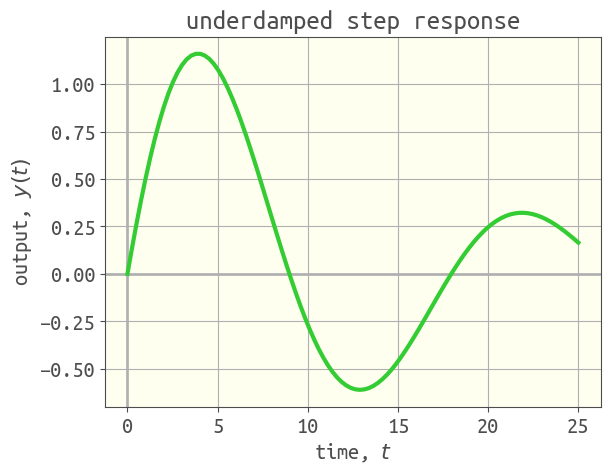

In [12]:
##
# second order, underdamped
K = 4.3
τ = 2.8
ξ = 0.2
g = K / (τ ^ 2 * s ^ 2 + 2 * τ * ξ * s + 1)
# impulse response
t, y = simulate(g, (0.0, 25.0))

viz_response(t, y, plot_title="underdamped step response")

In [13]:
g = zeros_poles_gain([2*im, -2*im, 3], [-4, -5, -6], 13.0)

-130.0*s^3 + 390.0*s^2 - 520.0*s + 1560.0
-----------------------------------------
        s^3 + 15*s^2 + 74*s + 120

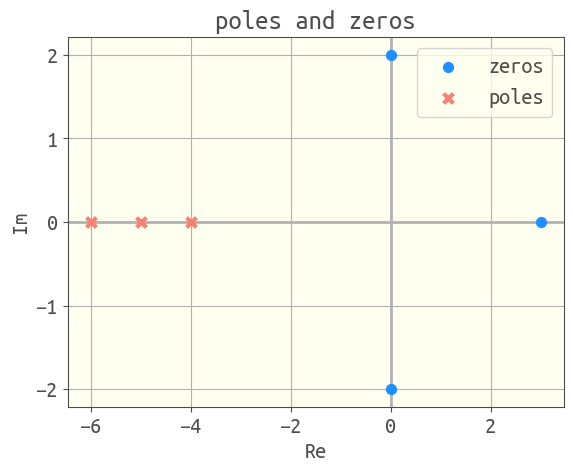

In [14]:
viz_poles_and_zeros(g)

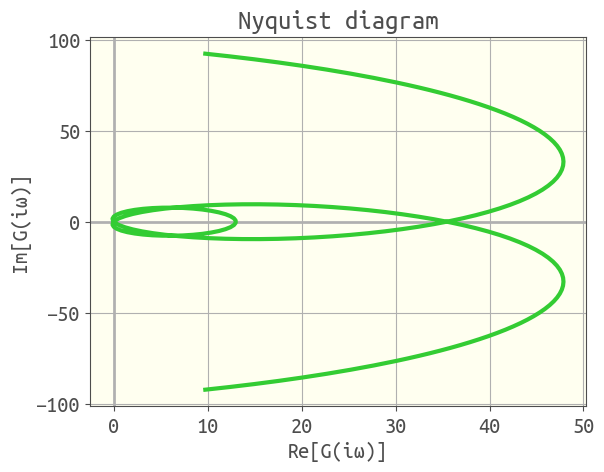

In [15]:
viz_nyquist_diagram(g)

In [16]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)
@show g_ol
c_poly = characteristic_polynomial(g_ol)

g_ol =               4.0
--------------------------------
1.0*s^3 + 6.0*s^2 + 11.0*s + 6.0


Poly(10.0 + 11.0*s + 6.0*s^2 + 1.0*s^3)

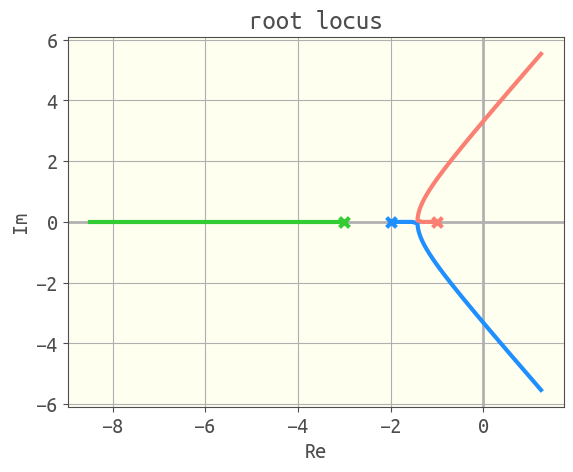

In [17]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)

viz_root_locus(g_ol)